In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmath

In [3]:
#import data generated in MATLAB
physical_real=np.loadtxt(r'/content/300_Physical_matrices_Dim=4_RealPart.txt')
Non_physical_real=np.loadtxt(r'/content/300_Non_Physical_matrices_Dim=4_RealPart.txt')
physical_imag=np.loadtxt(r'/content/300_Physical_matrices_Dim=4_ImagPart.txt')
Non_physical_imag=np.loadtxt(r'/content/300_Non_Physical_matrices_Dim=4_ImagPart.txt')

################ TO CREATE THE DATASET #############

#Classifier: 0-> Physical matrix, 1-> Non physical matrix
target_Physical=np.zeros((physical_real.shape[0],1),dtype=int)
target_NonPhysical=np.ones((physical_real.shape[0],1),dtype=int)

Physical_real=np.concatenate((physical_real,target_Physical), axis=1)
Physical_imag=np.concatenate((physical_imag,target_Physical), axis=1)
NonPhysical_real=np.concatenate((Non_physical_real,target_NonPhysical), axis=1)
NonPhysical_imag=np.concatenate((Non_physical_imag,target_NonPhysical), axis=1)
Physical_data=np.stack((Physical_real,Physical_imag),axis=2)
NonPhysical_data=np.stack((NonPhysical_real,NonPhysical_imag),axis=2)
#print("Physical data size:  ", Physical_data.shape, ", Non Physical data size: ", NonPhysical_data.shape)

dataset=np.concatenate((Physical_data, NonPhysical_data), axis=0)
print("Dataset dimension", dataset.shape)

features=dataset[:,:-1,:]
target=dataset[:,-1,1]
print("features size: ", features.shape, ", target size: ", target.shape)


Dataset dimension (600, 17, 2)
features size:  (600, 16, 2) , target size:  (600,)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.33, shuffle=True)
print("X_train: ",X_train.shape,", X_val: " ,X_val.shape, ", Y_train: ", Y_train.shape, ", Y_val: ",Y_val.shape)

X_train:  (402, 16, 2) , X_val:  (198, 16, 2) , Y_train:  (402,) , Y_val:  (198,)


In [5]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation,Conv1D, AveragePooling1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [6]:
featureArrayLength = (X_train.shape[1],X_train.shape[2])
dropoutRate = 0.25

In [16]:
inputList = Input(shape=(featureArrayLength))
neurons=[10,20,35,55,75]
kernel_size=[1,4,8,16]
models=[]

for n in neurons:
  for k in kernel_size:
    x = Conv1D(n, kernel_size=k, data_format="channels_last", strides=1, padding="valid", activation='relu')(inputList)
    x = Flatten()(x)
    x = Dense(25, activation='relu')(x)
    x = Dropout(dropoutRate)(x)
    x = Dense(15, activation='relu')(x)
    x = Dropout(dropoutRate)(x)
    output = Dense(1, activation='sigmoid')(x)
####
    model = Model(inputs=inputList, outputs=output)
    models=np.append(models,model)

In [17]:
for m in models:
  m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  m.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d (Conv1D)             (None, 16, 10)            30        
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 25)                4025      
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                390       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0     

In [18]:
batch_size = 30
n_epochs = 250

histories=[]

for m in models:
  m.summary()
  # train
  history = m.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
  _, train_acc = m.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = m.evaluate(X_val, Y_val, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
  print('#####################################')
  histories=np.append(histories,history)
  del history, train_acc, val_acc

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d (Conv1D)             (None, 16, 10)            30        
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 25)                4025      
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                390       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0     

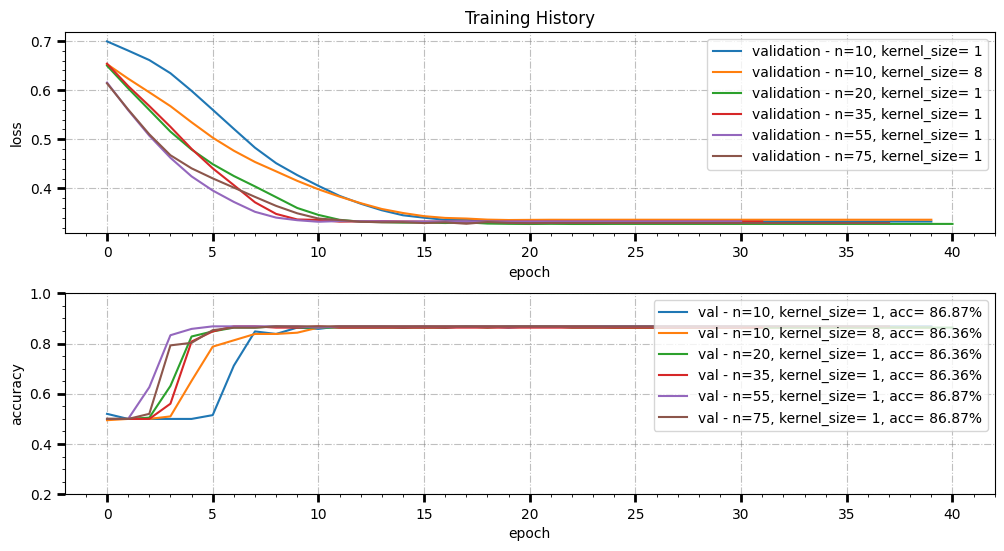

In [26]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(12, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=0.3, wspace=0.3)

j=0
for i,hist in enumerate(histories):
  if models[i].layers[1].output.shape[1]==16:
    j=0
  if hist.history['val_accuracy'][-1]>0.86:
    #ax0.plot(hist.history['loss'],label='training - n='+ str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j]))
    ax0.plot(hist.history['val_loss'], label='validation - n='+str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j]))
  j=j+1
#ax0.set_yscale('log')
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')

for i,hist in enumerate(histories):
  if models[i].layers[1].output.shape[1]==16:
    j=0
  if hist.history['val_accuracy'][-1]>0.86:
    #ax1.plot(hist.history['accuracy'],label='train - n='+ str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j])+', acc= '+ str(np.round(hist.history['accuracy'][-1]*100.,2)))
    ax1.plot(hist.history['val_accuracy'], label='val - n='+ str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j])+', acc= '+ str(np.round(hist.history['val_accuracy'][-1]*100.,2))+'%')
  j=j+1
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.2,1)
ax1.legend(loc='upper right')
plt.show()

7/7 [==============================] - 0s 2ms/step


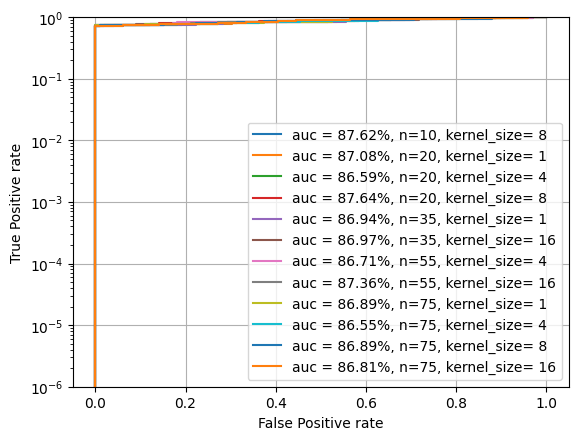

In [28]:
import pandas as pd
from sklearn.metrics import roc_curve, auc

predict_val =[]
fpr=[]
tpr=[]
auc1=[]


for i,m in enumerate(models):
  predicted=m.predict(X_val)
  if i==0:
    predict_val=predicted
  else:
    predict_val=np.concatenate((predict_val,predicted),axis=1)



df = pd.DataFrame()
plt.figure()

j=0
for i in range(predict_val.shape[1]):
  if models[i].layers[1].output.shape[1]==16:
    j=0
  fpr_, tpr_, threshold = roc_curve(Y_val,predict_val[:,i])
  auc_= auc(fpr_, tpr_)
  if auc_>0.865:
    plt.plot(fpr_,tpr_,label='auc = '+ str(np.round(auc_*100.,2))+'%, n='+ str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j]))
  j=j+1
plt.semilogy()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()


sembra che l'accuratezza migliore si raggiunga con kerenel=1, provo a fissare n=75 e cambiare il kernel in un range tra 1 e 4.

In [29]:
inputList = Input(shape=(featureArrayLength))

kernel_size=[1,2,3,4]
models2=[]

for k in kernel_size:
  x = Conv1D(75, kernel_size=k, data_format="channels_last", strides=1, padding="valid", activation='relu')(inputList)
  x = Flatten()(x)
  x = Dense(25, activation='relu')(x)
  x = Dropout(dropoutRate)(x)
  x = Dense(15, activation='relu')(x)
  x = Dropout(dropoutRate)(x)
  output = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=inputList, outputs=output)
  models2=np.append(models2,model)

In [30]:
for m in models2:
  m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  m.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d_20 (Conv1D)          (None, 16, 75)            225       
                                                                 
 flatten_20 (Flatten)        (None, 1200)              0         
                                                                 
 dense_60 (Dense)            (None, 25)                30025     
                                                                 
 dropout_40 (Dropout)        (None, 25)                0         
                                                                 
 dense_61 (Dense)            (None, 15)                390       
                                                                 
 dropout_41 (Dropout)        (None, 15)                0  

In [31]:
batch_size = 30
n_epochs = 250

histories2=[]

for m in models2:
  m.summary()
  # train
  history = m.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
  _, train_acc = m.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = m.evaluate(X_val, Y_val, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
  print('#####################################')
  histories2=np.append(histories2,history)
  del history, train_acc, val_acc

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d_20 (Conv1D)          (None, 16, 75)            225       
                                                                 
 flatten_20 (Flatten)        (None, 1200)              0         
                                                                 
 dense_60 (Dense)            (None, 25)                30025     
                                                                 
 dropout_40 (Dropout)        (None, 25)                0         
                                                                 
 dense_61 (Dense)            (None, 15)                390       
                                                                 
 dropout_41 (Dropout)        (None, 15)                0  

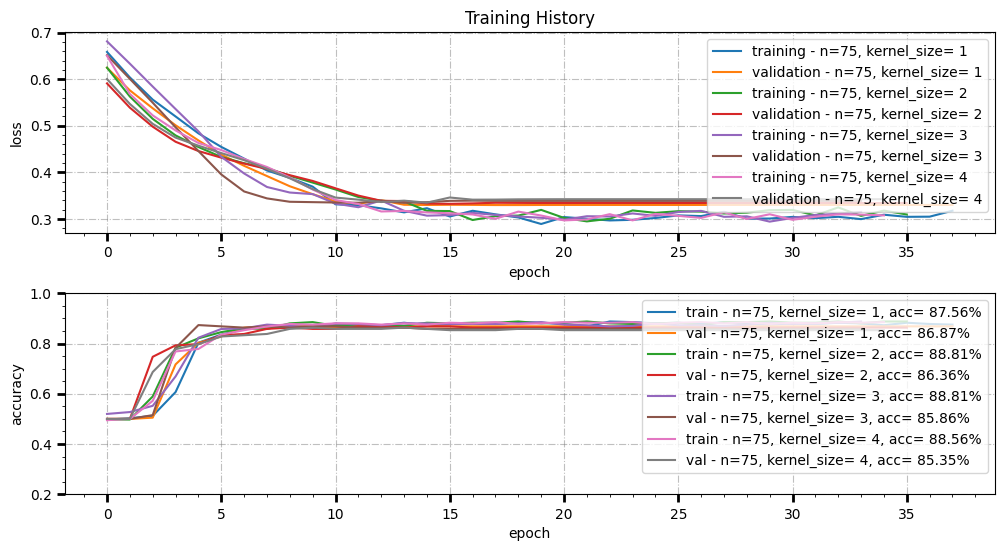

In [33]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(12, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=0.3, wspace=0.3)


for i,hist in enumerate(histories2):
  ax0.plot(hist.history['loss'],label='training - n=75, kernel_size= ' + str(kernel_size[i]))
  ax0.plot(hist.history['val_loss'], label='validation - n=75, kernel_size= ' + str(kernel_size[i]))

#ax0.set_yscale('log')
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')

for i,hist in enumerate(histories2):
  ax1.plot(hist.history['accuracy'],label='train - n=75, kernel_size= ' + str(kernel_size[i])+', acc= '+ str(np.round(hist.history['accuracy'][-1]*100.,2))+'%')
  ax1.plot(hist.history['val_accuracy'], label='val - n=75, kernel_size= ' + str(kernel_size[i])+', acc= '+ str(np.round(hist.history['val_accuracy'][-1]*100.,2))+'%')

ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.2,1)
ax1.legend(loc='upper right')
plt.show()

Sembra che la kernel size =1 sia ancora la migliore.

Provo a vedere se usado un kernel=2 e il pooling migliora la situa.

In [38]:
inputList = Input(shape=(featureArrayLength))

x = Conv1D(75, kernel_size=4, data_format="channels_last", strides=1, padding="valid", activation='relu')(inputList)
x = AveragePooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(25, activation='relu')(x)
x = Dropout(dropoutRate)(x)
x = Dense(15, activation='relu')(x)
x = Dropout(dropoutRate)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputList, outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()




Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d_26 (Conv1D)          (None, 13, 75)            675       
                                                                 
 average_pooling1d_2 (Averag  (None, 6, 75)            0         
 ePooling1D)                                                     
                                                                 
 flatten_26 (Flatten)        (None, 450)               0         
                                                                 
 dense_78 (Dense)            (None, 25)                11275     
                                                                 
 dropout_52 (Dropout)        (None, 25)                0         
                                                          

In [39]:
batch_size = 30
n_epochs = 250


  # train
history = model.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
_, train_acc = m.evaluate(X_train, Y_train, verbose=0)
_, val_acc = m.evaluate(X_val, Y_val, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
print('#####################################')


Epoch 1/250
14/14 - 2s - loss: 0.6925 - accuracy: 0.5473 - val_loss: 0.6771 - val_accuracy: 0.5000 - lr: 0.0010 - 2s/epoch - 134ms/step
Epoch 2/250
14/14 - 0s - loss: 0.6648 - accuracy: 0.5423 - val_loss: 0.6514 - val_accuracy: 0.5000 - lr: 0.0010 - 90ms/epoch - 6ms/step
Epoch 3/250
14/14 - 0s - loss: 0.6421 - accuracy: 0.5274 - val_loss: 0.6175 - val_accuracy: 0.4949 - lr: 0.0010 - 86ms/epoch - 6ms/step
Epoch 4/250
14/14 - 0s - loss: 0.6078 - accuracy: 0.6318 - val_loss: 0.5667 - val_accuracy: 0.6667 - lr: 0.0010 - 85ms/epoch - 6ms/step
Epoch 5/250
14/14 - 0s - loss: 0.5477 - accuracy: 0.7836 - val_loss: 0.5089 - val_accuracy: 0.8636 - lr: 0.0010 - 83ms/epoch - 6ms/step
Epoch 6/250
14/14 - 0s - loss: 0.5007 - accuracy: 0.8458 - val_loss: 0.4534 - val_accuracy: 0.8687 - lr: 0.0010 - 85ms/epoch - 6ms/step
Epoch 7/250
14/14 - 0s - loss: 0.4433 - accuracy: 0.8483 - val_loss: 0.4063 - val_accuracy: 0.8687 - lr: 0.0010 - 86ms/epoch - 6ms/step
Epoch 8/250
14/14 - 0s - loss: 0.4198 - accuracy

sembra non cambiare niente, ho provato con diversi kernel e average pool

provo ad aggiungere un Conv layer

In [41]:
inputList = Input(shape=(featureArrayLength))

neurons= [20,35,50]
kernel_size=[1,2,4,8,16]
models3=[]
for n in neurons:
  for k in kernel_size:
    x = Conv1D(75, kernel_size=1, data_format="channels_last", strides=1, padding="valid", activation='relu')(inputList)
    x = Conv1D(n, kernel_size=k, data_format="channels_last", strides=1, padding="valid", activation='relu')(x)

    x = Flatten()(x)
    x = Dense(25, activation='relu')(x)
    x = Dropout(dropoutRate)(x)
    x = Dense(15, activation='relu')(x)
    x = Dropout(dropoutRate)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputList, outputs=output)
    models3=np.append(models3,model)



In [56]:
for m in models3:
  m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  m.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d_57 (Conv1D)          (None, 16, 75)            225       
                                                                 
 conv1d_58 (Conv1D)          (None, 16, 20)            1520      
                                                                 
 flatten_42 (Flatten)        (None, 320)               0         
                                                                 
 dense_126 (Dense)           (None, 25)                8025      
                                                                 
 dropout_84 (Dropout)        (None, 25)                0         
                                                                 
 dense_127 (Dense)           (None, 15)                390

In [43]:
batch_size = 30
n_epochs = 250

histories3=[]

for m in models3:
  m.summary()
  # train
  history = m.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
  _, train_acc = m.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = m.evaluate(X_val, Y_val, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
  print('#####################################')
  histories3=np.append(histories3,history)
  del history, train_acc, val_acc

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d_57 (Conv1D)          (None, 16, 75)            225       
                                                                 
 conv1d_58 (Conv1D)          (None, 16, 20)            1520      
                                                                 
 flatten_42 (Flatten)        (None, 320)               0         
                                                                 
 dense_126 (Dense)           (None, 25)                8025      
                                                                 
 dropout_84 (Dropout)        (None, 25)                0         
                                                                 
 dense_127 (Dense)           (None, 15)                390

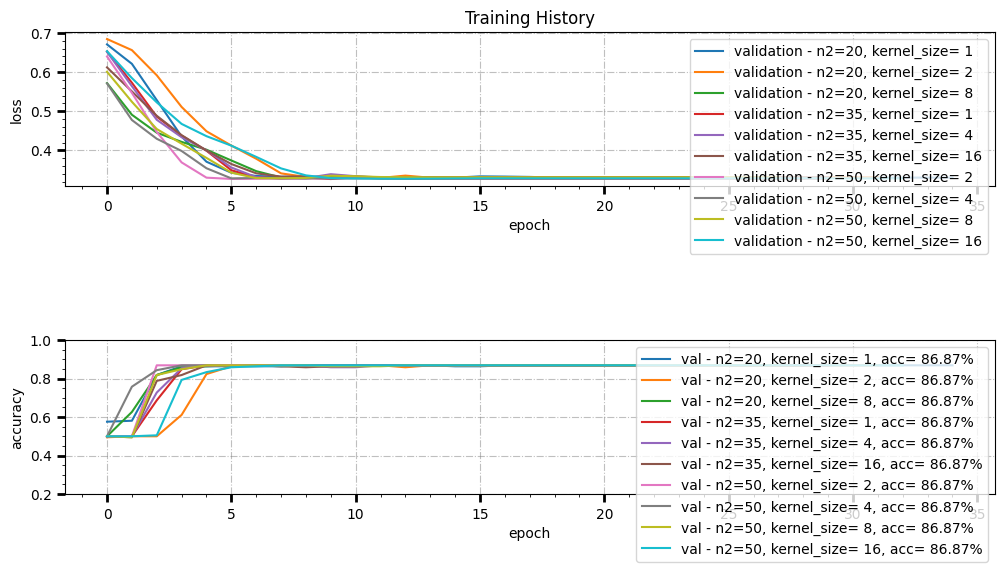

In [49]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(12, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=1, wspace=0.3)

j=0
for i,hist in enumerate(histories3):
  if models3[i].layers[2].output.shape[1]==16:
    j=0
  if hist.history['val_accuracy'][-1]>0.865:
    #ax0.plot(hist.history['loss'],label='training - n='+ str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j]))
    ax0.plot(hist.history['val_loss'], label='validation - n2='+str(models3[i].layers[2].output.shape[2])+', kernel_size= ' + str(kernel_size[j]))
  j=j+1
#ax0.set_yscale('log')
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')

for i,hist in enumerate(histories3):
  if models3[i].layers[2].output.shape[1]==16:
    j=0
  if hist.history['val_accuracy'][-1]>0.865:
    #ax1.plot(hist.history['accuracy'],label='train - n='+ str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j])+', acc= '+ str(np.round(hist.history['accuracy'][-1]*100.,2)))
    ax1.plot(hist.history['val_accuracy'], label='val - n2='+ str(models3[i].layers[2].output.shape[2])+', kernel_size= ' + str(kernel_size[j])+', acc= '+ str(np.round(hist.history['val_accuracy'][-1]*100.,2))+'%')
  j=j+1
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.2,1)
ax1.legend(loc='upper right')
plt.show()

7/7 [==============================] - 0s 2ms/step


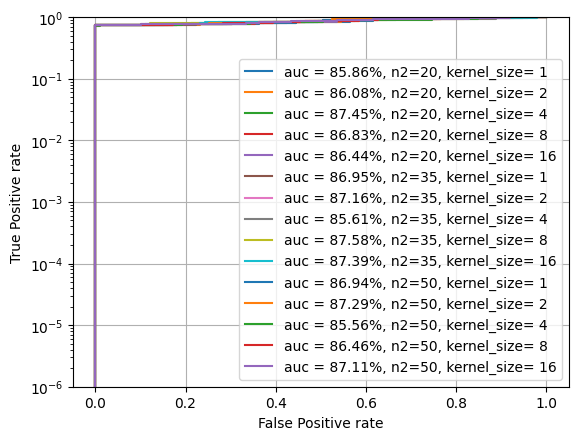

In [53]:
import pandas as pd
from sklearn.metrics import roc_curve, auc

predict_val =[]
fpr=[]
tpr=[]
auc1=[]


for i,m in enumerate(models3):
  predicted=m.predict(X_val)
  if i==0:
    predict_val=predicted
  else:
    predict_val=np.concatenate((predict_val,predicted),axis=1)



df = pd.DataFrame()
plt.figure()

j=0
for i in range(predict_val.shape[1]):
  if models3[i].layers[2].output.shape[1]==16:
    j=0
  fpr_, tpr_, threshold = roc_curve(Y_val,predict_val[:,i])
  auc_= auc(fpr_, tpr_)
  plt.plot(fpr_,tpr_,label='auc = '+ str(np.round(auc_*100.,2))+'%, n2='+ str(models3[i].layers[2].output.shape[2])+', kernel_size= ' + str(kernel_size[j]))
  j=j+1
plt.semilogy()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()



per quanto riguarda l'accuratezza sembra essere tutto uguale, mentre il migliore parametro AUC lo abbiamo nel caso di n2=35 e una kernel size di 8.

provo a cambiare il dropout rate e aggiungere il pooling in questo caso.

In [58]:
inputList = Input(shape=(featureArrayLength))

pooling_size=[1,2,3,4,5,9]
models4=[]
for p in pooling_size:
  x = Conv1D(75, kernel_size=1, data_format="channels_last", strides=1, padding="valid", activation='relu')(inputList)
  x = Conv1D(35, kernel_size=8, data_format="channels_last", strides=1, padding="valid", activation='relu')(x)
  x = AveragePooling1D(pool_size=p)(x)
  x = Flatten()(x)
  x = Dense(25, activation='relu')(x)
  x = Dropout(dropoutRate)(x)
  x = Dense(15, activation='relu')(x)
  x = Dropout(dropoutRate)(x)
  output = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=inputList, outputs=output)
  models4=np.append(models4,model)

In [59]:
for m in models4:
  m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  m.summary()

Model: "model_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 16, 2)]           0         
                                                                 
 conv1d_99 (Conv1D)          (None, 16, 75)            225       
                                                                 
 conv1d_100 (Conv1D)         (None, 9, 35)             21035     
                                                                 
 average_pooling1d_9 (Averag  (None, 9, 35)            0         
 ePooling1D)                                                     
                                                                 
 flatten_63 (Flatten)        (None, 315)               0         
                                                                 
 dense_189 (Dense)           (None, 25)                7900      
                                                          

In [60]:
batch_size = 30
n_epochs = 250

histories4=[]

for m in models4:
  m.summary()
  # train
  history = m.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
  _, train_acc = m.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = m.evaluate(X_val, Y_val, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
  print('#####################################')
  histories4=np.append(histories4,history)
  del history, train_acc, val_acc

Model: "model_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 16, 2)]           0         
                                                                 
 conv1d_99 (Conv1D)          (None, 16, 75)            225       
                                                                 
 conv1d_100 (Conv1D)         (None, 9, 35)             21035     
                                                                 
 average_pooling1d_9 (Averag  (None, 9, 35)            0         
 ePooling1D)                                                     
                                                                 
 flatten_63 (Flatten)        (None, 315)               0         
                                                                 
 dense_189 (Dense)           (None, 25)                7900      
                                                          

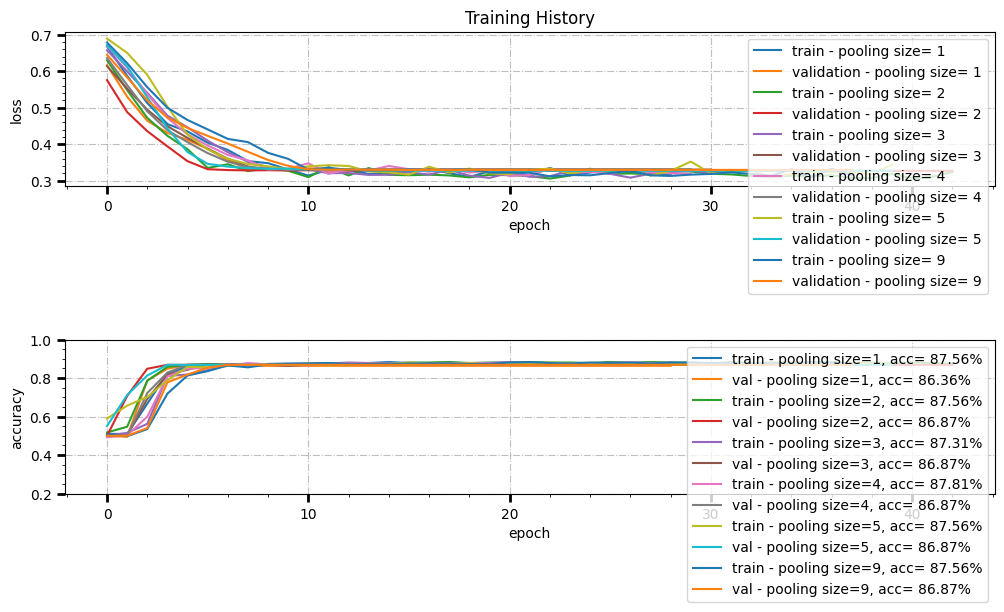

In [66]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(12, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=1, wspace=0.3)

for i,hist in enumerate(histories4):
  ax0.plot(hist.history['loss'],label= 'train - pooling size= '+ str(pooling_size[i]))
  ax0.plot(hist.history['val_loss'], label='validation - pooling size= '+ str(pooling_size[i]))

#ax0.set_yscale('log')
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')

for i,hist in enumerate(histories4):
  ax1.plot(hist.history['accuracy'],label='train - pooling size='+ str(pooling_size[i])+', acc= '+str(np.round(hist.history['accuracy'][-1]*100.,2))+'%')
  ax1.plot(hist.history['val_accuracy'], label='val - pooling size='+ str(pooling_size[i])+', acc= '+str(np.round(hist.history['val_accuracy'][-1]*100.,2))+'%')

ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.2,1)
ax1.legend(loc='upper right')
plt.show()

anche quin non sembra cambiare una beata minchia, provo ancor a a cambiare il numeo di neuroni negli ultimi 2 layers che sono un MLP e poi basta

In [7]:
inputList = Input(shape=(featureArrayLength))

neurons1=[15,25,35,50]
neurons2=[1,10,15,20,25]
models5=[]

for n1 in neurons1:
  for n2 in neurons2:
    x = Conv1D(75, kernel_size=1, data_format="channels_last", strides=1, padding="valid", activation='relu')(inputList)
    x = Conv1D(35, kernel_size=8, data_format="channels_last", strides=1, padding="valid", activation='relu')(x)
    x = AveragePooling1D(pool_size=9)(x)
    x = Flatten()(x)
    x = Dense(n1, activation='relu')(x)
    x = Dropout(dropoutRate)(x)
    x = Dense(n2, activation='relu')(x)
    x = Dropout(dropoutRate)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputList, outputs=output)
    models5=np.append(models5,model)

In [8]:
for m in models5:
  m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d (Conv1D)             (None, 16, 75)            225       
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 35)             21035     
                                                                 
 average_pooling1d (AverageP  (None, 1, 35)            0         
 ooling1D)                                                       
                                                                 
 flatten (Flatten)           (None, 35)                0         
                                                                 
 dense (Dense)               (None, 15)                540       
                                                             

In [9]:
batch_size = 30
n_epochs = 250

histories5=[]

for m in models5:
  m.summary()
  # train
  history = m.fit(X_train, Y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, Y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])
  _, train_acc = m.evaluate(X_train, Y_train, verbose=0)
  _, val_acc = m.evaluate(X_val, Y_val, verbose=0)
  print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
  print('#####################################')
  histories5=np.append(histories5,history)
  del history, train_acc, val_acc

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 2)]           0         
                                                                 
 conv1d (Conv1D)             (None, 16, 75)            225       
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 35)             21035     
                                                                 
 average_pooling1d (AverageP  (None, 1, 35)            0         
 ooling1D)                                                       
                                                                 
 flatten (Flatten)           (None, 35)                0         
                                                                 
 dense (Dense)               (None, 15)                540       
                                                             

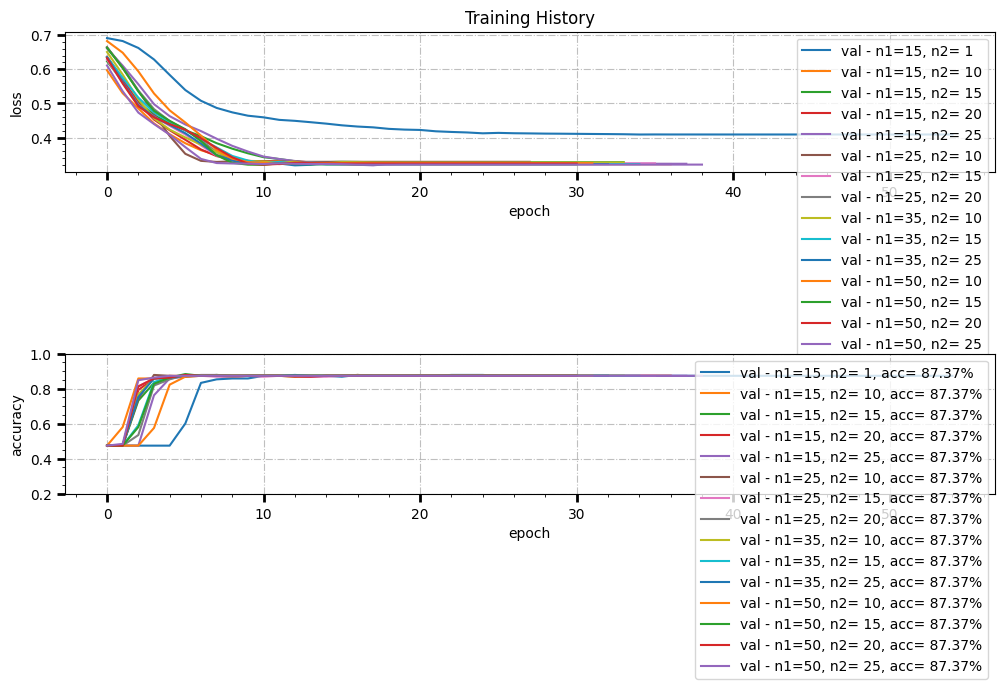

In [24]:
# plot training history

fig, ((ax0,ax1)) = plt.subplots(figsize=(12, 6), ncols=1, nrows=2)
for ax in fig.get_axes():
  ax.minorticks_on()
  ax.tick_params(axis='x', which='both', direction='out')
  ax.grid(True,which='major', axis='both',linestyle='-.')
  ax.tick_params(direction='out', length=6, width=2, colors='k',grid_color='gray', grid_alpha=0.5)

plt.subplots_adjust(hspace=1.3, wspace=0.3)


for i,hist in enumerate(histories5):
  if hist.history['val_accuracy'][-1]>0.87:
    #ax0.plot(hist.history['loss'],label='training - n='+ str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j]))
    ax0.plot(hist.history['val_loss'],label= 'val - n1='+str(models5[i].layers[5].output.shape[1])+', n2= ' + str(models5[i].layers[7].output.shape[1]))
#ax0.set_yscale('log')
ax0.set_title('Training History')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(loc='upper right')

for i,hist in enumerate(histories5):
  if hist.history['val_accuracy'][-1]>0.87:
    #ax1.plot(hist.history['accuracy'],label='train - n='+ str(models[i].layers[1].output.shape[2])+', kernel_size= ' + str(kernel_size[j])+', acc= '+ str(np.round(hist.history['accuracy'][-1]*100.,2)))
    ax1.plot(hist.history['val_accuracy'],label= 'val - n1='+str(models5[i].layers[5].output.shape[1])+', n2= ' + str(models5[i].layers[7].output.shape[1])+', acc= '+ str(np.round(hist.history['val_accuracy'][-1]*100.,2))+'%')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylim(0.2,1)
ax1.legend(loc='upper right')
plt.show()

7/7 [==============================] - 0s 5ms/step


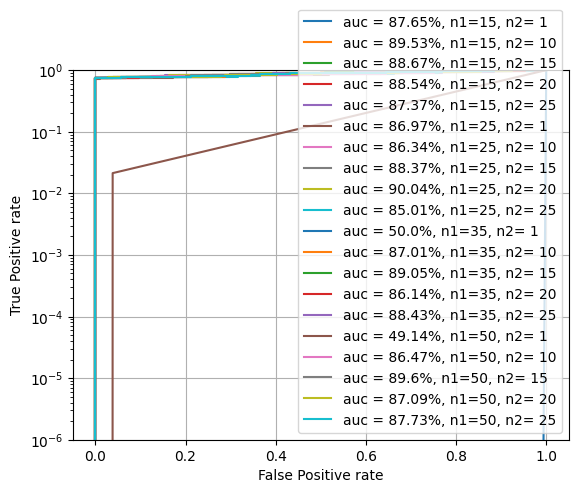

In [25]:
import pandas as pd
from sklearn.metrics import roc_curve, auc

predict_val =[]
fpr=[]
tpr=[]
auc1=[]


for i,m in enumerate(models5):
  predicted=m.predict(X_val)
  if i==0:
    predict_val=predicted
  else:
    predict_val=np.concatenate((predict_val,predicted),axis=1)



df = pd.DataFrame()
plt.figure()


for i in range(predict_val.shape[1]):
  fpr_, tpr_, threshold = roc_curve(Y_val,predict_val[:,i])
  auc_= auc(fpr_, tpr_)
  plt.plot(fpr_,tpr_,label='auc = '+ str(np.round(auc_*100.,2))+'%, n1='+str(models5[i].layers[5].output.shape[1])+', n2= ' + str(models5[i].layers[7].output.shape[1]))

plt.semilogy()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

ok a quanto pare il migliore sembra essere n1=25, n2=20 con AUC=90.04% e val accuracy= 87.37%